# Simple LPG

In [1]:
from pathlib import Path
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

warnings.filterwarnings("ignore")

PREV_MAX = 80
if os.environ.get("KAGGLE_DATA_PROXY_TOKEN") != None:
    BASE_OUTPUT_PATH = Path(f'/kaggle/working')
    BASE_INPUT_PATH = Path(f'/kaggle/input/optiver-trading-at-the-close')
    TRAIN_FILE = Path(f'{BASE_INPUT_PATH}/train.csv')
    TEST_FILE = Path(f'{BASE_INPUT_PATH}/test.csv')
    IS_OFFLINE = False
    DEVICE = "gpu"

    # subprocess.check_call([sys.executable, "-m", "pip", "install", "talib_binary", "--no-index", "--find-links", "file:///kaggle/input/ta-lib/"])
else:
    BASE_OUTPUT_PATH = Path(f'../output')
    BASE_INPUT_PATH = Path(f'../kaggle/input/optiver-trading-at-the-close')
    TRAIN_FILE = Path(f'{BASE_INPUT_PATH}/train.csv')
    TEST_FILE = Path(f'{BASE_INPUT_PATH}/test.csv')
    SAMPLE_SUBMISSION_FILE = Path(f'{BASE_INPUT_PATH}/sample_submission.csv')
    REVEALED_TARGETS_FILE = Path(f'{BASE_INPUT_PATH}/revealed_targets.csv')
    IS_OFFLINE = True
    DEVICE = "cpu"

print(f"BASE_OUTPUT_PATH: {BASE_OUTPUT_PATH}")
print(f"BASE_INPUT_PATH: {BASE_INPUT_PATH}")
print(f"TRAIN_FILE: {TRAIN_FILE}")
print(f"TEST_FILE: {TEST_FILE}")
print(f"IS_OFFLINE: {IS_OFFLINE}")


BASE_OUTPUT_PATH: ../output
BASE_INPUT_PATH: ../kaggle/input/optiver-trading-at-the-close
TRAIN_FILE: ../kaggle/input/optiver-trading-at-the-close/train.csv
TEST_FILE: ../kaggle/input/optiver-trading-at-the-close/test.csv
IS_OFFLINE: True


In [2]:
from typing import Sequence, Tuple

import pandas as pd


class MockApi:
    def __init__(self):
        '''
        YOU MUST UPDATE THE FIRST THREE LINES of this method.
        They've been intentionally left in an invalid state.

        Variables to set:
            input_paths: a list of two or more paths to the csv files to be served
            group_id_column: the column that identifies which groups of rows the API should serve.
                A call to iter_test serves all rows of all dataframes with the current group ID value.
            export_group_id_column: if true, the dataframes iter_test serves will include the group_id_column values.
        '''
        self.input_paths: Sequence[str] = [TEST_FILE, REVEALED_TARGETS_FILE, SAMPLE_SUBMISSION_FILE]
        self.group_id_column: str = 'time_id'
        self.export_group_id_column: bool = True
        # iter_test is only designed to support at least two dataframes, such as test and sample_submission
        assert len(self.input_paths) >= 2

        self._status = 'initialized'
        self.predictions = []

    def iter_test(self) -> Tuple[pd.DataFrame]:
        '''
        Loads all of the dataframes specified in self.input_paths,
        then yields all rows in those dataframes that equal the current self.group_id_column value.
        '''
        if self._status != 'initialized':

            raise Exception('WARNING: the real API can only iterate over `iter_test()` once.')

        dataframes = []
        for pth in self.input_paths:
            dataframes.append(pd.read_csv(pth, low_memory=False))
        group_order = dataframes[0][self.group_id_column].drop_duplicates().tolist()
        dataframes = [df.set_index(self.group_id_column) for df in dataframes]

        for group_id in group_order:
            self._status = 'prediction_needed'
            current_data = []
            for df in dataframes:
                cur_df = df.loc[group_id].copy()
                # returning single line dataframes from df.loc requires special handling
                if not isinstance(cur_df, pd.DataFrame):
                    cur_df = pd.DataFrame({a: b for a, b in zip(cur_df.index.values, cur_df.values)}, index=[group_id])
                    cur_df.index.name = self.group_id_column
                cur_df = cur_df.reset_index(drop=not(self.export_group_id_column))
                current_data.append(cur_df)
            yield tuple(current_data)

            while self._status != 'prediction_received':
                print('You must call `predict()` successfully before you can continue with `iter_test()`', flush=True)
                yield None

        with open('submission.csv', 'w') as f_open:
            pd.concat(self.predictions).to_csv(f_open, index=False)
        self._status = 'finished'

    def predict(self, user_predictions: pd.DataFrame):
        '''
        Accepts and stores the user's predictions and unlocks iter_test once that is done
        '''
        if self._status == 'finished':
            raise Exception('You have already made predictions for the full test set.')
        if self._status != 'prediction_needed':
            raise Exception('You must get the next test sample from `iter_test()` first.')
        if not isinstance(user_predictions, pd.DataFrame):
            raise Exception('You must provide a DataFrame.')

        self.predictions.append(user_predictions)
        self._status = 'prediction_received'


def make_env():
    return MockApi()

In [3]:
train_dataset = pd.read_csv(TRAIN_FILE)

In [6]:
features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

train_dataset_drop = train_dataset[features+['target', 'stock_id', 'date_id']].dropna()


[I 2023-11-12 21:49:34,801] A new study created in memory with name: no-name-29f73c5b-e8bc-4d40-80b0-6e053997e8e3


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:50:42,533] Trial 0 finished with value: 8.879555593034185 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 8.879555593034185.


Early stopping, best iteration is:
[520]	Train's rmse: 9.41267	Valid's rmse: 8.87956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:51:25,233] Trial 1 finished with value: 8.883861179712088 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 8.879555593034185.


Early stopping, best iteration is:
[290]	Train's rmse: 9.42038	Valid's rmse: 8.88386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:52:35,060] Trial 2 finished with value: 8.877632405368791 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 8.877632405368791.


Early stopping, best iteration is:
[526]	Train's rmse: 9.40665	Valid's rmse: 8.87763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:52:56,635] Trial 3 finished with value: 8.883337705631815 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 8.877632405368791.


Early stopping, best iteration is:
[290]	Train's rmse: 9.42132	Valid's rmse: 8.88334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:53:31,312] Trial 4 finished with value: 8.877632405368791 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 8.877632405368791.


Early stopping, best iteration is:
[526]	Train's rmse: 9.40665	Valid's rmse: 8.87763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:54:00,287] Trial 5 finished with value: 8.87841652414287 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 8.877632405368791.


Early stopping, best iteration is:
[445]	Train's rmse: 9.4069	Valid's rmse: 8.87842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:54:33,730] Trial 6 finished with value: 8.87709432105288 and parameters: {'feature_fraction': 0.8}. Best is trial 6 with value: 8.87709432105288.
feature_fraction, val_score: 8.877094: 100%|##########| 7/7 [04:58<00:00, 42.70s/it]


Early stopping, best iteration is:
[525]	Train's rmse: 9.40392	Valid's rmse: 8.87709


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:55:15,258] Trial 7 finished with value: 8.869803212145255 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 8.869803212145255.


Early stopping, best iteration is:
[445]	Train's rmse: 9.3787	Valid's rmse: 8.8698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:55:54,050] Trial 8 finished with value: 8.875580499975529 and parameters: {'num_leaves': 9}. Best is trial 7 with value: 8.869803212145255.


Early stopping, best iteration is:
[691]	Train's rmse: 9.39754	Valid's rmse: 8.87558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:56:51,910] Trial 9 finished with value: 8.86492794841708 and parameters: {'num_leaves': 227}. Best is trial 9 with value: 8.86492794841708.


Early stopping, best iteration is:
[300]	Train's rmse: 9.30744	Valid's rmse: 8.86493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:57:55,829] Trial 10 finished with value: 8.865969194332624 and parameters: {'num_leaves': 249}. Best is trial 9 with value: 8.86492794841708.


Early stopping, best iteration is:
[302]	Train's rmse: 9.30123	Valid's rmse: 8.86597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 21:58:58,799] Trial 11 finished with value: 8.86542134818168 and parameters: {'num_leaves': 254}. Best is trial 9 with value: 8.86492794841708.


Early stopping, best iteration is:
[285]	Train's rmse: 9.30508	Valid's rmse: 8.86542
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:00:00,583] Trial 12 finished with value: 8.866565587849392 and parameters: {'num_leaves': 255}. Best is trial 9 with value: 8.86492794841708.


Early stopping, best iteration is:
[285]	Train's rmse: 9.30485	Valid's rmse: 8.86657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:01:10,058] Trial 13 finished with value: 8.864087421299443 and parameters: {'num_leaves': 186}. Best is trial 13 with value: 8.864087421299443.


Early stopping, best iteration is:
[366]	Train's rmse: 9.3033	Valid's rmse: 8.86409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:02:17,336] Trial 14 finished with value: 8.864039126923338 and parameters: {'num_leaves': 162}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[368]	Train's rmse: 9.31146	Valid's rmse: 8.86404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:03:26,545] Trial 15 finished with value: 8.864831205319996 and parameters: {'num_leaves': 153}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[366]	Train's rmse: 9.31496	Valid's rmse: 8.86483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:04:39,438] Trial 16 finished with value: 8.865121776466314 and parameters: {'num_leaves': 157}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[366]	Train's rmse: 9.3137	Valid's rmse: 8.86512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:05:38,894] Trial 17 finished with value: 8.866365082933363 and parameters: {'num_leaves': 103}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[334]	Train's rmse: 9.34144	Valid's rmse: 8.86637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:06:54,365] Trial 18 finished with value: 8.865255654936377 and parameters: {'num_leaves': 194}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[366]	Train's rmse: 9.30086	Valid's rmse: 8.86526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:07:59,738] Trial 19 finished with value: 8.865665260608548 and parameters: {'num_leaves': 120}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[366]	Train's rmse: 9.32824	Valid's rmse: 8.86567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:09:12,096] Trial 20 finished with value: 8.864683887490918 and parameters: {'num_leaves': 191}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[358]	Train's rmse: 9.30356	Valid's rmse: 8.86468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:10:22,692] Trial 21 finished with value: 8.86527381280311 and parameters: {'num_leaves': 195}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[329]	Train's rmse: 9.30878	Valid's rmse: 8.86527
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:11:36,552] Trial 22 finished with value: 8.865606561908784 and parameters: {'num_leaves': 184}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[350]	Train's rmse: 9.30751	Valid's rmse: 8.86561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:12:39,182] Trial 23 finished with value: 8.867438867738219 and parameters: {'num_leaves': 86}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[366]	Train's rmse: 9.34392	Valid's rmse: 8.86744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:13:50,360] Trial 24 finished with value: 8.864559624401386 and parameters: {'num_leaves': 161}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[367]	Train's rmse: 9.31199	Valid's rmse: 8.86456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:14:59,215] Trial 25 finished with value: 8.864838576334408 and parameters: {'num_leaves': 151}. Best is trial 14 with value: 8.864039126923338.


Early stopping, best iteration is:
[362]	Train's rmse: 9.31682	Valid's rmse: 8.86484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:15:50,614] Trial 26 finished with value: 8.868725894029046 and parameters: {'num_leaves': 76}. Best is trial 14 with value: 8.864039126923338.
num_leaves, val_score: 8.864039: 100%|##########| 20/20 [21:16<00:00, 63.84s/it]


Early stopping, best iteration is:
[310]	Train's rmse: 9.35882	Valid's rmse: 8.86873


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:16:57,655] Trial 27 finished with value: 8.87036323454161 and parameters: {'bagging_fraction': 0.9721315759821091, 'bagging_freq': 6}. Best is trial 27 with value: 8.87036323454161.


Early stopping, best iteration is:
[260]	Train's rmse: 9.33107	Valid's rmse: 8.87036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:17:59,961] Trial 28 finished with value: 8.865828840645191 and parameters: {'bagging_fraction': 0.43068389222001735, 'bagging_freq': 1}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[302]	Train's rmse: 9.32746	Valid's rmse: 8.86583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:19:09,664] Trial 29 finished with value: 8.866689528427594 and parameters: {'bagging_fraction': 0.6922213000303734, 'bagging_freq': 2}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[304]	Train's rmse: 9.32201	Valid's rmse: 8.86669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:20:20,026] Trial 30 finished with value: 8.870584140495733 and parameters: {'bagging_fraction': 0.9651321318091812, 'bagging_freq': 7}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[261]	Train's rmse: 9.33077	Valid's rmse: 8.87058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:21:19,231] Trial 31 finished with value: 8.866395286763577 and parameters: {'bagging_fraction': 0.40053429504590793, 'bagging_freq': 4}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[299]	Train's rmse: 9.32926	Valid's rmse: 8.8664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:22:19,341] Trial 32 finished with value: 8.869828970542134 and parameters: {'bagging_fraction': 0.6989304240962115, 'bagging_freq': 4}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[248]	Train's rmse: 9.3381	Valid's rmse: 8.86983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:23:15,089] Trial 33 finished with value: 8.868122471239879 and parameters: {'bagging_fraction': 0.5678522709807621, 'bagging_freq': 3}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[257]	Train's rmse: 9.33626	Valid's rmse: 8.86812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:24:22,006] Trial 34 finished with value: 8.870145306565844 and parameters: {'bagging_fraction': 0.8580327223289081, 'bagging_freq': 6}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[280]	Train's rmse: 9.32687	Valid's rmse: 8.87015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:25:19,275] Trial 35 finished with value: 8.86843055831902 and parameters: {'bagging_fraction': 0.8209475481854687, 'bagging_freq': 1}. Best is trial 28 with value: 8.865828840645191.


Early stopping, best iteration is:
[303]	Train's rmse: 9.32083	Valid's rmse: 8.86843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:26:19,785] Trial 36 finished with value: 8.866928753573415 and parameters: {'bagging_fraction': 0.5502413876782193, 'bagging_freq': 5}. Best is trial 28 with value: 8.865828840645191.
bagging, val_score: 8.864039: 100%|##########| 10/10 [10:29<00:00, 62.92s/it]


Early stopping, best iteration is:
[280]	Train's rmse: 9.33065	Valid's rmse: 8.86693


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:27:38,070] Trial 37 finished with value: 8.864039126923338 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 8.864039126923338.


Early stopping, best iteration is:
[368]	Train's rmse: 9.31146	Valid's rmse: 8.86404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:28:44,262] Trial 38 finished with value: 8.865792160053116 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 8.864039126923338.


Early stopping, best iteration is:
[289]	Train's rmse: 9.3322	Valid's rmse: 8.86579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:29:46,570] Trial 39 finished with value: 8.869640844558969 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 8.864039126923338.


Early stopping, best iteration is:
[265]	Train's rmse: 9.33537	Valid's rmse: 8.86964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:31:03,260] Trial 40 finished with value: 8.864039126923338 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 8.864039126923338.


Early stopping, best iteration is:
[368]	Train's rmse: 9.31146	Valid's rmse: 8.86404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:32:24,688] Trial 41 finished with value: 8.864039126923338 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 8.864039126923338.


Early stopping, best iteration is:
[368]	Train's rmse: 9.31146	Valid's rmse: 8.86404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:33:22,138] Trial 42 finished with value: 8.869640844558969 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 8.864039126923338.
feature_fraction_stage2, val_score: 8.864039: 100%|##########| 6/6 [07:02<00:00, 70.39s/it]


Early stopping, best iteration is:
[265]	Train's rmse: 9.33537	Valid's rmse: 8.86964


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:34:25,369] Trial 43 finished with value: 8.86569637505769 and parameters: {'lambda_l1': 0.0029579161153396485, 'lambda_l2': 1.4850126664684918e-08}. Best is trial 43 with value: 8.86569637505769.


Early stopping, best iteration is:
[310]	Train's rmse: 9.32303	Valid's rmse: 8.8657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:35:39,647] Trial 44 finished with value: 8.86396684024901 and parameters: {'lambda_l1': 1.3368205848687324e-08, 'lambda_l2': 2.122661013283473}. Best is trial 44 with value: 8.86396684024901.


Early stopping, best iteration is:
[366]	Train's rmse: 9.31462	Valid's rmse: 8.86397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:36:54,088] Trial 45 finished with value: 8.86109466106118 and parameters: {'lambda_l1': 1.608646753202705e-08, 'lambda_l2': 8.907218252451582}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32202	Valid's rmse: 8.86109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:38:20,969] Trial 46 finished with value: 8.863113969704399 and parameters: {'lambda_l1': 1.4605259379966952e-08, 'lambda_l2': 5.46699720919058}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[370]	Train's rmse: 9.3186	Valid's rmse: 8.86311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:39:56,294] Trial 47 finished with value: 8.861377849559618 and parameters: {'lambda_l1': 2.415834450144256e-08, 'lambda_l2': 7.65743935244623}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[366]	Train's rmse: 9.32174	Valid's rmse: 8.86138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:41:09,661] Trial 48 finished with value: 8.86214811571829 and parameters: {'lambda_l1': 1.1161164824937951e-08, 'lambda_l2': 6.264339690264147}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[370]	Train's rmse: 9.31951	Valid's rmse: 8.86215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:42:18,590] Trial 49 finished with value: 8.862116503006536 and parameters: {'lambda_l1': 1.1661395963236522e-08, 'lambda_l2': 4.8970797100285735}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[372]	Train's rmse: 9.31753	Valid's rmse: 8.86212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:43:28,897] Trial 50 finished with value: 8.861387450502649 and parameters: {'lambda_l1': 1.4177710476101629e-08, 'lambda_l2': 9.11098767025311}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32205	Valid's rmse: 8.86139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:44:38,765] Trial 51 finished with value: 8.861177954918478 and parameters: {'lambda_l1': 1.3346430159679186e-08, 'lambda_l2': 8.002084121826963}. Best is trial 45 with value: 8.86109466106118.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32121	Valid's rmse: 8.86118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:45:49,379] Trial 52 finished with value: 8.861048933534265 and parameters: {'lambda_l1': 1.2316210260228139e-08, 'lambda_l2': 9.509994236689533}. Best is trial 52 with value: 8.861048933534265.


Early stopping, best iteration is:
[362]	Train's rmse: 9.324	Valid's rmse: 8.86105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:47:00,130] Trial 53 finished with value: 8.862456470935289 and parameters: {'lambda_l1': 1.240485083514064e-08, 'lambda_l2': 6.798356263295387}. Best is trial 52 with value: 8.861048933534265.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32009	Valid's rmse: 8.86246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:48:10,012] Trial 54 finished with value: 8.861475994991613 and parameters: {'lambda_l1': 1.5884522727390526e-08, 'lambda_l2': 8.723263128984543}. Best is trial 52 with value: 8.861048933534265.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32175	Valid's rmse: 8.86148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:49:19,772] Trial 55 finished with value: 8.860487715363353 and parameters: {'lambda_l1': 6.007867133350991e-08, 'lambda_l2': 9.159132000399245}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32234	Valid's rmse: 8.86049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:50:28,694] Trial 56 finished with value: 8.86265261365902 and parameters: {'lambda_l1': 9.674943955175542e-07, 'lambda_l2': 4.725734694628693}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[370]	Train's rmse: 9.31788	Valid's rmse: 8.86265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:51:36,171] Trial 57 finished with value: 8.864875486296546 and parameters: {'lambda_l1': 1.0389503005470686e-06, 'lambda_l2': 0.1891359363793723}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[363]	Train's rmse: 9.31163	Valid's rmse: 8.86488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:52:43,266] Trial 58 finished with value: 8.864579341315824 and parameters: {'lambda_l1': 6.344359190531186e-07, 'lambda_l2': 0.08483637825037992}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[366]	Train's rmse: 9.31103	Valid's rmse: 8.86458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:53:50,451] Trial 59 finished with value: 8.864931204762469 and parameters: {'lambda_l1': 0.9519342139765671, 'lambda_l2': 0.3239804360661611}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[368]	Train's rmse: 9.31121	Valid's rmse: 8.86493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:55:00,894] Trial 60 finished with value: 8.86077384252165 and parameters: {'lambda_l1': 1.7497628972737454e-07, 'lambda_l2': 9.040493553855157}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[370]	Train's rmse: 9.32226	Valid's rmse: 8.86077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:56:11,311] Trial 61 finished with value: 8.86054669631315 and parameters: {'lambda_l1': 1.6232731492780336e-07, 'lambda_l2': 9.605951555296157}. Best is trial 55 with value: 8.860487715363353.


Early stopping, best iteration is:
[370]	Train's rmse: 9.3225	Valid's rmse: 8.86055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:57:18,109] Trial 62 finished with value: 8.864757585058873 and parameters: {'lambda_l1': 2.0930548608312315e-07, 'lambda_l2': 0.6475007061930125}. Best is trial 55 with value: 8.860487715363353.
regularization_factors, val_score: 8.860488: 100%|##########| 20/20 [23:55<00:00, 71.80s/it]


Early stopping, best iteration is:
[364]	Train's rmse: 9.31252	Valid's rmse: 8.86476


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 22:58:48,241] Trial 63 finished with value: 8.855286134960801 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 8.855286134960801.


Early stopping, best iteration is:
[443]	Train's rmse: 9.32523	Valid's rmse: 8.85529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 23:00:00,618] Trial 64 finished with value: 8.858316433029344 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 8.855286134960801.


Early stopping, best iteration is:
[366]	Train's rmse: 9.33164	Valid's rmse: 8.85832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 23:01:11,023] Trial 65 finished with value: 8.860051416092727 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 8.855286134960801.


Early stopping, best iteration is:
[365]	Train's rmse: 9.32734	Valid's rmse: 8.86005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 23:02:19,639] Trial 66 finished with value: 8.861887121483091 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 8.855286134960801.


Early stopping, best iteration is:
[366]	Train's rmse: 9.32144	Valid's rmse: 8.86189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4742815, number of used features: 9
[LightGBM] [Info] Start training from score -0.042787
Training until validation scores don't improve for 10 rounds


[I 2023-11-12 23:03:29,980] Trial 67 finished with value: 8.860487715363353 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 8.855286134960801.
min_child_samples, val_score: 8.855286: 100%|##########| 5/5 [06:11<00:00, 74.37s/it]

Early stopping, best iteration is:
[370]	Train's rmse: 9.32234	Valid's rmse: 8.86049


KeyError: 'Train'

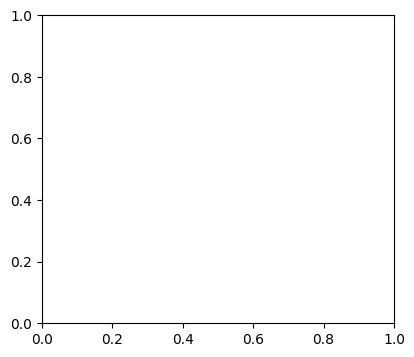

In [12]:
import optuna.integration.lightgbm as lgb

split_day = 435  # Split day for time series data
df_train = train_dataset_drop[train_dataset_drop["date_id"] <= split_day]
df_valid = train_dataset_drop[train_dataset_drop["date_id"] > split_day]

seed=2023

# 目的変数と説明変数の分離
X_train = df_train[features]
y_train = df_train['target']

X_valid = df_valid[features]
y_valid = df_valid['target']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
        'task': 'train',                   # 学習
        'boosting_type': 'gbdt',           # GBDT
        'objective': 'regression',         # 回帰
        'metric': 'rmse',                  # 損失（誤差）
        'learning_rate': 0.01,             # 学習率
        'lambda_l1': 0.5,                  # L1正則化項の係数
        'lambda_l2': 0.5,                  # L2正則化項の係数
        'num_leaves': 10,                  # 最大葉枚数
        'feature_fraction': 0.5,           # ランダムに抽出される列の割合
        'bagging_fraction': 0.5,           # ランダムに抽出される標本の割合
        'bagging_freq': 5,                 # バギング実施頻度
        'min_child_samples': 10,           # 葉に含まれる最小データ数
        'seed': seed,                       # シード値
        'device': DEVICE
    } 

lgb_results = {}
verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される

model = lgb.train( 
    params,                            # ハイパーパラメータ
    lgb_train,                         # 訓練データ
    valid_sets=[lgb_train, lgb_valid], # 検証データ
    valid_names=['Train', 'Valid'],    # データセット名前
    num_boost_round=2000,              # 計算回数
    callbacks=[lgb.early_stopping(stopping_rounds=10, 
                verbose=True), # early_stopping用コールバック関数
            lgb.log_evaluation(verbose_eval)]
) 

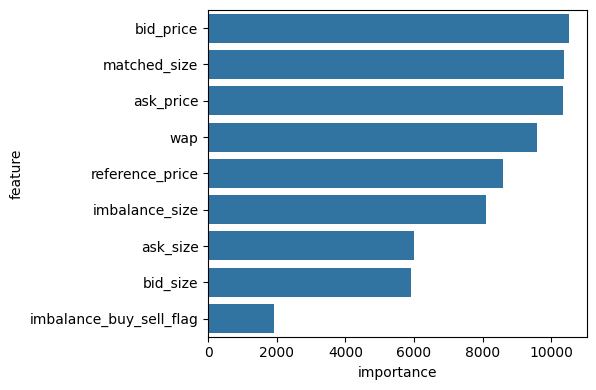

In [15]:
################################
# 結果描画
################################
fig = plt.figure(figsize=(10, 4))

# loss
plt.subplot(1,2,1)
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Valid']['rmse']   
plt.xlabel('Iteration')
plt.ylabel('logloss')
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='valid loss')
plt.legend()

# feature importance
plt.subplot(1,2,2)
importance = pd.DataFrame({'feature':features, 'importance':model.feature_importance()})
sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

plt.tight_layout()
plt.show()

# Test

In [13]:
if IS_OFFLINE:
    env = make_env()
else:
    import optiver2023
    env = optiver2023.make_env()
iter_test = env.iter_test()


for (test, revealed_targets, sample_prediction) in iter_test:
    
    test_X = test[features]
    predictions = model.predict(test_X)

    # sample_prediction に予測結果をセット
    sample_prediction['target'] = predictions

    # 予測を提出
    env.predict(sample_prediction)